In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import gc
import lightgbm as lgb
from sklearn.metrics import precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt

# Prepare data

In [2]:
dtypes = {
    'ip'            : 'uint32',
    'app'           : 'uint16',
    'device'        : 'uint16',
    'os'            : 'uint16',
    'channel'       : 'uint16',
    'is_attributed' : 'uint8',
    'click_id'      : 'uint32'
}

In [3]:
train_usecols = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']

In [4]:
%%time
train = pd.read_csv('../data/train.csv', dtype=dtypes, usecols=train_usecols)

CPU times: user 1min 8s, sys: 3.81 s, total: 1min 12s
Wall time: 1min 14s


In [5]:
%%time
train.loc[:, 'click_time'] = pd.to_datetime(train.click_time, format='%Y-%m-%d %H:%M:%S')

CPU times: user 22.9 s, sys: 2.85 s, total: 25.7 s
Wall time: 22.1 s


In [6]:
train.loc[:, 'day'] = train.click_time.dt.day.astype('uint8')

In [7]:
train.loc[:, 'hour'] = train.click_time.dt.hour.astype('uint8')

In [8]:
train.head()

,ip,app,device,os,channel,click_time,is_attributed,day,hour
0,83230,3,1,13,379,2017-11-06 14:32:21,0,6,14
1,17357,3,1,19,379,2017-11-06 14:33:34,0,6,14
2,35810,3,1,13,379,2017-11-06 14:34:12,0,6,14
3,45745,14,1,13,478,2017-11-06 14:34:52,0,6,14
4,161007,3,1,13,379,2017-11-06 14:35:08,0,6,14


In [11]:
%%time
train.drop(['click_time'], axis=1, inplace=True)

CPU times: user 2.31 s, sys: 1.14 s, total: 3.44 s
Wall time: 911 ms


In [12]:
gc.collect()

37

In [9]:
train = train.loc[train.day.isin([7, 8])].copy()

In [13]:
train.head()

,ip,app,device,os,channel,is_attributed,day,hour
9308568,70712,2,1,32,237,0,7,0
9308569,45892,3,1,25,424,0,7,0
9308570,37774,8,2,13,145,0,7,0
9308571,41179,2,1,13,122,0,7,0
9308572,83111,15,1,8,245,0,7,0


In [14]:
most_freq_hours_in_test_data = [4, 5, 9, 10, 13, 14]
least_freq_hours_in_test_data = [6, 11, 15]

In [16]:
train.loc[:, 'in_test_hh'] = (
    3 - 2*train.hour.isin(most_freq_hours_in_test_data) - 1*train.hour.isin(least_freq_hours_in_test_data)
).astype('uint8')

In [17]:
%%time
gp = train[['ip', 'day', 'in_test_hh', 'channel']].groupby(
    ['ip', 'day', 'in_test_hh']
)[['channel']].count().reset_index().rename(index=str, columns={'channel': 'nip_day_test_hh'})

CPU times: user 12 s, sys: 4.47 s, total: 16.5 s
Wall time: 12.5 s


In [18]:
train = train.merge(gp, on=['ip','day','in_test_hh'], how='left')

In [19]:
del gp

In [21]:
train.drop(['in_test_hh'], axis=1, inplace=True)

In [22]:
print( "nip_day_test_hh max value = ", train.nip_day_test_hh.max())

nip_day_test_hh max value =  208661


In [23]:
train.loc[:, 'nip_day_test_hh'] = train.nip_day_test_hh.astype('uint32')

In [24]:
gc.collect()

180

In [25]:
gp = train[['ip', 'day', 'hour', 'channel']].groupby(by=['ip', 'day', 
             'hour'])[['channel']].count().reset_index().rename(index=str, 
             columns={'channel': 'nip_day_hh'})
train = train.merge(gp, on=['ip','day','hour'], how='left')
del gp
print( "nip_day_hh max value = ", train.nip_day_hh.max() )
train.loc[:, 'nip_day_hh'] = train['nip_day_hh'].astype('uint16')
gc.collect()

nip_day_hh max value =  44259


110

In [26]:
gp = train[['ip', 'day', 'os', 'hour', 'channel']].groupby(by=['ip', 'os', 'day',
             'hour'])[['channel']].count().reset_index().rename(index=str, 
             columns={'channel': 'nip_hh_os'})
train = train.merge(gp, on=['ip','os','hour','day'], how='left')
del gp
print( "nip_hh_os max value = ", train.nip_hh_os.max() )
train.loc[:, 'nip_hh_os'] = train['nip_hh_os'].astype('uint16')
gc.collect()

nip_hh_os max value =  9824


125

In [27]:
gp = train[['ip', 'app', 'hour', 'day', 'channel']].groupby(by=['ip', 'app', 'day',
             'hour'])[['channel']].count().reset_index().rename(index=str, 
             columns={'channel': 'nip_hh_app'})
train = train.merge(gp, on=['ip','app','hour','day'], how='left')
del gp
print( "nip_hh_app max value = ", train.nip_hh_app.max() )
train.loc[:, 'nip_hh_app'] = train['nip_hh_app'].astype('uint16')
gc.collect()

nip_hh_app max value =  7592


125

In [ ]:
%%time
gp = train[['ip', 'device', 'hour', 'day', 'channel']].groupby(by=['ip', 'device', 'day',
             'hour'])[['channel']].count().reset_index().rename(index=str, 
             columns={'channel': 'nip_hh_dev'})
train = train.merge(gp, on=['ip','device','day','hour'], how='left')
del gp
print( "nip_hh_dev max value = ", train.nip_hh_dev.max() )

In [29]:
train.loc[:, 'nip_hh_dev'] = train['nip_hh_dev'].astype('uint32')
gc.collect()

143

In [30]:
train.head()

,ip,app,device,os,channel,is_attributed,day,hour,nip_day_test_hh,nip_day_hh,nip_hh_os,nip_hh_app,nip_hh_dev
0,70712,2,1,32,237,0,7,0,974,90,2,25,88
1,45892,3,1,25,424,0,7,0,2594,328,18,88,328
2,37774,8,2,13,145,0,7,0,6737,788,147,62,41
3,41179,2,1,13,122,0,7,0,302,47,1,4,47
4,83111,15,1,8,245,0,7,0,1161,153,3,13,152


In [31]:
%%time
colname = 'nip_dh_app_os'
gp = train[['ip', 'day', 'hour', 'app', 'os', 'channel']].groupby(by=['ip', 'day', 'hour', 'app',
             'os'])[['channel']].count().reset_index().rename(index=str, 
             columns={'channel': colname})
train = train.merge(gp, on=['ip', 'day', 'hour', 'app', 'os'], how='left')
del gp
print("{} max value = ".format(colname), train[colname].max() )
train.loc[:, colname] = train[colname].astype('uint16')
gc.collect()

nip_dh_app_os max value =  1853
CPU times: user 2min 5s, sys: 42.9 s, total: 2min 48s
Wall time: 3min 37s


In [32]:
%%time
colname = 'ndh_app'
gp = train[['day', 'hour', 'app', 'channel']].groupby(by=['day', 'hour', 
             'app'])[['channel']].count().reset_index().rename(index=str, 
             columns={'channel': colname})
train = train.merge(gp, on=['day', 'hour', 'app'], how='left')
del gp
print("{} max value = ".format(colname), train[colname].max() )
train.loc[:, colname] = train[colname].astype('uint32')
gc.collect()

ndh_app max value =  842094
CPU times: user 36.5 s, sys: 28.9 s, total: 1min 5s
Wall time: 32.1 s


In [33]:
valid = train.loc[train.day == 7].copy()
train = train.loc[train.day == 8].copy()

In [40]:
train.drop(['ip', 'day'], axis=1, inplace=True)

In [41]:
valid.drop(['ip', 'day'], axis=1, inplace=True)

ValueError: labels ['ip' 'day'] not contained in axis

In [ ]:
gc.collect()

In [36]:
%%time
train.to_hdf('../derived_data/kaggle_popular.hdf', key='train')

CPU times: user 1.71 s, sys: 2 s, total: 3.71 s
Wall time: 7.63 s


In [37]:
%%time
valid.to_hdf('../derived_data/kaggle_popular.hdf', key='valid')

CPU times: user 2.44 s, sys: 1.94 s, total: 4.39 s
Wall time: 10.2 s


In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62945075 entries, 59633310 to 122578384
Data columns (total 15 columns):
ip                 uint32
app                uint16
device             uint16
os                 uint16
channel            uint16
is_attributed      uint8
day                uint8
hour               uint8
nip_day_test_hh    uint32
nip_day_hh         uint16
nip_hh_os          uint16
nip_hh_app         uint16
nip_hh_dev         uint32
nip_dh_app_os      uint16
ndh_app            uint32
dtypes: uint16(8), uint32(4), uint8(3)
memory usage: 2.5 GB


# Random forest

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
rfc = RandomForestClassifier(n_estimators=23, n_jobs=4, class_weight={0: 1, 1: 300})

In [85]:
input_features = ['app', 'apps', 'app_ent',
                  'device', 'devices', 'device_ent',
                  'os', 'oss', 'os_ent',
                  'channel', 'channels', 'channel_ent',
                  'minute', 'clicks']
input_features = ['app', 'channel', 'minute']
label = 'is_attributed'

In [38]:
train.shape

(59632496, 15)

In [39]:
valid.shape

(62945075, 15)

In [86]:
%%time
rfc.fit(train.loc[:, input_features], train.loc[:, label])

CPU times: user 45min 6s, sys: 1min, total: 46min 7s
Wall time: 12min 37s


RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 300},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=23, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [87]:
pred_prob = rfc.predict_proba(valid.loc[:, input_features])[:, 1]

In [88]:
pred = (pred_prob > 0.5).astype('uint8')

In [89]:
len(np.unique(pred_prob))

51019

In [90]:
precision_score(valid.loc[:, label], pred)

0.08513816686072923

In [91]:
recall_score(valid.loc[:, label], pred)

0.7163076160473777

In [92]:
roc_auc_score(valid.loc[:, label], pred_prob)

0.8789456476967574

In [93]:
valid.loc[:, 'pred'] = pred
valid.loc[:, 'pred_prob'] = pred_prob

In [62]:
valid.loc[(valid.pred_prob > .99) & (valid.is_attributed == 1)].head()

,app,device,os,channel,is_attributed,minute,clicks,apps,app_ent,devices,device_ent,oss,os_ent,channels,channel_ent,pred,pred_prob
68945925,35,1,18,274,1,0,1,1,0.0,1,0.0,1,0.0,1,0.0,1,1.000000
68964705,35,1,19,274,1,0,1,1,0.0,1,0.0,1,0.0,1,0.0,1,1.000000
68971329,19,0,21,213,1,0,1,1,0.0,1,0.0,1,0.0,1,0.0,1,0.998281
68985910,35,1,18,274,1,0,1,1,0.0,1,0.0,1,0.0,1,0.0,1,1.000000
68987188,19,0,21,213,1,0,1,1,0.0,1,0.0,1,0.0,1,0.0,1,0.998281


In [63]:
valid.loc[(valid.pred_prob > .99) & (valid.is_attributed == 1)].tail()

,app,device,os,channel,is_attributed,minute,clicks,apps,app_ent,devices,device_ent,oss,os_ent,channels,channel_ent,pred,pred_prob
131774766,35,1,13,274,1,1437,1,1,0.0,1,0.0,1,0.0,1,0.0,1,1.000
131782159,35,1,13,274,1,1437,1,1,0.0,1,0.0,1,0.0,1,0.0,1,1.000
131810723,19,0,29,213,1,1438,1,1,0.0,1,0.0,1,0.0,1,0.0,1,0.998
131844428,35,1,16,274,1,1439,1,1,0.0,1,0.0,1,0.0,1,0.0,1,1.000
131861612,35,1,15,274,1,1439,1,1,0.0,1,0.0,1,0.0,1,0.0,1,1.000


In [64]:
valid.loc[(valid.pred_prob < .01) & (valid.is_attributed == 0)].head()

,app,device,os,channel,is_attributed,minute,clicks,apps,app_ent,devices,device_ent,oss,os_ent,channels,channel_ent,pred,pred_prob
68941878,23,1,13,153,0,0,30,12,2.218750,2,0.146118,7,1.560547,22,2.968750,0,0.0
68941879,13,1,16,477,0,0,13,10,2.244141,1,0.000000,3,0.925293,8,1.991211,0,0.0
68941880,12,1,13,259,0,0,2,2,0.693359,1,0.000000,1,0.000000,2,0.693359,0,0.0
68941881,15,1,19,265,0,0,14,9,2.107422,2,0.257324,3,0.758789,13,2.539062,0,0.0
68941882,6,1,18,125,0,0,12,6,1.583008,1,0.000000,1,0.000000,10,2.253906,0,0.0


In [65]:
valid.loc[(valid.pred_prob < .01) & (valid.is_attributed == 0)].tail()

,app,device,os,channel,is_attributed,minute,clicks,apps,app_ent,devices,device_ent,oss,os_ent,channels,channel_ent,pred,pred_prob
131886948,27,1,19,122,0,1439,3,3,1.098633,1,0.00000,1,0.000000,3,1.098633,0,0.0
131886949,3,1,17,409,0,1439,1,1,0.000000,1,0.00000,1,0.000000,1,0.000000,0,0.0
131886950,18,1,27,134,0,1439,10,9,2.164062,1,0.00000,1,0.000000,10,2.302734,0,0.0
131886951,15,1,13,245,0,1439,86,20,2.660156,2,0.54248,17,2.158203,39,3.351562,0,0.0
131886952,15,1,16,111,0,1439,6,3,1.011719,1,0.00000,2,0.636719,3,0.867676,0,0.0


In [66]:
valid.loc[(valid.pred_prob < .01) & (valid.is_attributed == 1)].head()

,app,device,os,channel,is_attributed,minute,clicks,apps,app_ent,devices,device_ent,oss,os_ent,channels,channel_ent,pred,pred_prob
68943564,18,1,18,121,1,0,6,5,1.560547,1,0.000000,2,0.693359,6,1.791992,0,0.0
68943698,9,1,19,466,1,0,6,6,1.791992,1,0.000000,1,0.000000,5,1.560547,0,0.0
68944635,20,1,19,478,1,0,6,6,1.791992,1,0.000000,1,0.000000,5,1.560547,0,0.0
68945054,19,0,0,213,1,0,22,13,2.324219,2,0.184937,6,1.362305,16,2.666016,0,0.0
68947389,21,1,17,232,1,0,6,5,1.560547,1,0.000000,2,0.450439,5,1.560547,0,0.0


In [68]:
valid.loc[(valid.pred_prob < .01) & (valid.is_attributed == 1)].tail()

,app,device,os,channel,is_attributed,minute,clicks,apps,app_ent,devices,device_ent,oss,os_ent,channels,channel_ent,pred,pred_prob
131876853,29,1,13,213,1,1439,1,1,0.000000,1,0.0,1,0.000000,1,0.000000,0,0.0
131883376,15,1,22,245,1,1439,3,3,1.098633,1,0.0,1,0.000000,3,1.098633,0,0.0
131885713,10,1,19,317,1,1439,5,5,1.609375,1,0.0,2,0.672852,4,1.332031,0,0.0
131886032,202,1,13,421,1,1439,21,9,1.976562,1,0.0,6,1.477539,13,2.238281,0,0.0
131886321,29,1,13,210,1,1439,3,3,1.098633,1,0.0,3,1.098633,3,1.098633,0,0.0


In [69]:
valid.loc[(valid.pred_prob > 0.99) & (valid.is_attributed == 0)].head()

,app,device,os,channel,is_attributed,minute,clicks,apps,app_ent,devices,device_ent,oss,os_ent,channels,channel_ent,pred,pred_prob
68950470,19,0,21,213,0,0,1,1,0.0,1,0.0,1,0.0,1,0.0,1,0.998281
68962722,19,0,21,213,0,0,1,1,0.0,1,0.0,1,0.0,1,0.0,1,0.998281
68963299,19,0,21,213,0,0,1,1,0.0,1,0.0,1,0.0,1,0.0,1,0.998281
68975987,19,0,21,213,0,0,1,1,0.0,1,0.0,1,0.0,1,0.0,1,0.998281
69223351,35,1,13,21,0,5,1,1,0.0,1,0.0,1,0.0,1,0.0,1,0.999304


In [70]:
valid.loc[(valid.pred_prob > 0.99) & (valid.is_attributed == 0)].tail()

,app,device,os,channel,is_attributed,minute,clicks,apps,app_ent,devices,device_ent,oss,os_ent,channels,channel_ent,pred,pred_prob
131795248,19,0,24,213,0,1438,1,1,0.0,1,0.0,1,0.0,1,0.0,1,0.998817
131811746,19,0,24,213,0,1438,1,1,0.0,1,0.0,1,0.0,1,0.0,1,0.998817
131814354,19,0,24,213,0,1438,1,1,0.0,1,0.0,1,0.0,1,0.0,1,0.998817
131830649,19,0,29,213,0,1438,1,1,0.0,1,0.0,1,0.0,1,0.0,1,0.998000
131831680,19,0,29,213,0,1438,1,1,0.0,1,0.0,1,0.0,1,0.0,1,0.998000


In [71]:
valid.loc[(valid.pred_prob > 0.49) & (valid.pred_prob < 0.51) & (valid.is_attributed == 0)].head()

,app,device,os,channel,is_attributed,minute,clicks,apps,app_ent,devices,device_ent,oss,os_ent,channels,channel_ent,pred,pred_prob
68942282,18,1,19,107,0,0,1,1,0.0,1,0.0,1,0.0,1,0.0,0,0.496396
68943112,18,1,19,107,0,0,1,1,0.0,1,0.0,1,0.0,1,0.0,0,0.496396
68943511,18,1,19,107,0,0,1,1,0.0,1,0.0,1,0.0,1,0.0,0,0.496396
68944199,18,1,19,107,0,0,1,1,0.0,1,0.0,1,0.0,1,0.0,0,0.496396
68944644,18,1,19,107,0,0,1,1,0.0,1,0.0,1,0.0,1,0.0,0,0.496396


In [72]:
valid.loc[(valid.pred_prob > 0.49) & (valid.pred_prob < 0.51) & (valid.is_attributed == 0)].tail()

,app,device,os,channel,is_attributed,minute,clicks,apps,app_ent,devices,device_ent,oss,os_ent,channels,channel_ent,pred,pred_prob
131746501,9,1,13,334,0,1436,1,1,0.0,1,0.0,1,0.0,1,0.0,0,0.508632
131746507,9,1,19,334,0,1436,1,1,0.0,1,0.0,1,0.0,1,0.0,0,0.508182
131746652,9,1,19,334,0,1436,1,1,0.0,1,0.0,1,0.0,1,0.0,0,0.508182
131746763,9,1,19,334,0,1436,1,1,0.0,1,0.0,1,0.0,1,0.0,0,0.508182
131747118,9,1,13,334,0,1436,1,1,0.0,1,0.0,1,0.0,1,0.0,0,0.508632


In [73]:
valid.loc[(valid.pred_prob > 0.49) & (valid.pred_prob < 0.51) & (valid.is_attributed == 1)].head()

,app,device,os,channel,is_attributed,minute,clicks,apps,app_ent,devices,device_ent,oss,os_ent,channels,channel_ent,pred,pred_prob
70917634,9,1,19,244,1,33,1,1,0.0,1,0.0,1,0.0,1,0.0,0,0.498986
72365337,9,1,19,334,1,58,1,1,0.0,1,0.0,1,0.0,1,0.0,0,0.490900
80870284,3,1,18,280,1,213,1,1,0.0,1,0.0,1,0.0,1,0.0,0,0.506169
83927020,9,1,19,244,1,268,1,1,0.0,1,0.0,1,0.0,1,0.0,0,0.499243
90419795,19,0,24,213,1,389,1,1,0.0,1,0.0,1,0.0,1,0.0,0,0.505132


In [74]:
valid.loc[(valid.pred_prob > 0.49) & (valid.pred_prob < 0.51) & (valid.is_attributed == 1)].tail()

,app,device,os,channel,is_attributed,minute,clicks,apps,app_ent,devices,device_ent,oss,os_ent,channels,channel_ent,pred,pred_prob
118961810,19,0,24,213,1,903,1,1,0.000000,1,0.0,1,0.0,1,0.000000,0,0.509614
118972186,19,0,24,213,1,903,1,1,0.000000,1,0.0,1,0.0,1,0.000000,0,0.509614
118978289,19,0,24,213,1,903,1,1,0.000000,1,0.0,1,0.0,1,0.000000,0,0.509614
128766632,24,1,19,105,1,1350,2,2,0.693359,1,0.0,1,0.0,2,0.693359,0,0.491711
131729768,9,1,13,334,1,1436,1,1,0.000000,1,0.0,1,0.0,1,0.000000,0,0.508632


In [94]:
importance = rfc.feature_importances_

In [95]:
importance

array([0.55535909, 0.31572601, 0.1289149 ])

In [96]:
importance_std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)

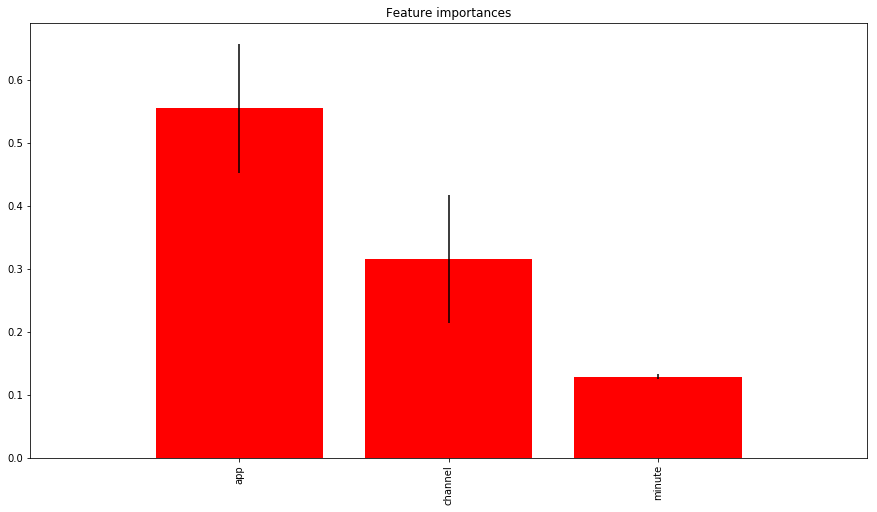

In [97]:
indices = np.argsort(importance)[::-1]
features = [input_features[i] for i in indices]
plt.figure(figsize=(15, 8))
plt.title("Feature importances")
plt.bar(range(train.loc[:, input_features].shape[1]), importance[indices], color="r", yerr=importance_std[indices], align="center")
plt.xticks(range(train.loc[:, input_features].shape[1]), features, rotation=90)
plt.xlim([-1, train.loc[:, input_features].shape[1]])
plt.show()

# Light GBM

In [43]:
predictors = ['app', 'device', 'os', 'channel', 'hour',
       'nip_day_test_hh', 'nip_day_hh', 'nip_hh_os', 'nip_hh_app',
       'nip_hh_dev', 'nip_dh_app_os', 'ndh_app']
target = 'is_attributed'

In [44]:
categorical = ['app', 'device', 'os', 'channel', 'hour']

In [45]:
gc.collect()

69

In [46]:
params = {
    'boosting_type': 'gbdt',  # I think dart would be better, but takes too long to run
    'drop_rate': 0.1,  # Rate at which to drop trees
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 7,  # Was 255: Reduced to control overfitting
    'max_depth': 4,  # Was 8: LightGBM splits leaf-wise, so control depth via num_leaves
    'min_child_samples': 100,
    'max_bin': 100,
    'subsample': 0.7,  # Was 0.7
    'subsample_freq': 1,
    'colsample_bytree': 0.7,
    'min_child_weight': 0,
    'subsample_for_bin': 200000,
    'min_split_gain': 0,
    'reg_alpha': 0,
    'reg_lambda': 0,
    'nthread': 8,
    'verbose': 0,
    'scale_pos_weight': 300
}

In [47]:
dtrain = lgb.Dataset(
    train.loc[:, predictors].values,
    label=train.loc[:, target].values,
    feature_name=predictors,
    categorical_feature=categorical
)

In [48]:
del train

In [49]:
gc.collect()

39

In [50]:
cv_results = lgb.cv(
    params=params,
    train_set=dtrain,
    nfold=3,
    num_boost_round=500,
    early_stopping_rounds=30,
    verbose_eval=20,
    categorical_feature=categorical
)

[20]	cv_agg's auc: 0.96764 + 0.000366179
[40]	cv_agg's auc: 0.973479 + 0.000207528
[60]	cv_agg's auc: 0.975729 + 0.000267437
[80]	cv_agg's auc: 0.976808 + 0.000253568
[100]	cv_agg's auc: 0.977408 + 0.000228626
[120]	cv_agg's auc: 0.977825 + 0.000206137
[140]	cv_agg's auc: 0.97808 + 0.000222925
[160]	cv_agg's auc: 0.978274 + 0.000226508
[180]	cv_agg's auc: 0.978422 + 0.000225431
[200]	cv_agg's auc: 0.978531 + 0.000214892
[220]	cv_agg's auc: 0.978633 + 0.000208496
[240]	cv_agg's auc: 0.978702 + 0.000203223
[260]	cv_agg's auc: 0.978773 + 0.000197214
[280]	cv_agg's auc: 0.978823 + 0.000199935
[300]	cv_agg's auc: 0.978879 + 0.000209579
[320]	cv_agg's auc: 0.9789 + 0.000191476
[340]	cv_agg's auc: 0.978936 + 0.000192812
[360]	cv_agg's auc: 0.978957 + 0.000203444
[380]	cv_agg's auc: 0.978975 + 0.00020712
[400]	cv_agg's auc: 0.979 + 0.000211288
[420]	cv_agg's auc: 0.979036 + 0.000208314
[440]	cv_agg's auc: 0.97905 + 0.000207213
[460]	cv_agg's auc: 0.979056 + 0.000215814
[480]	cv_agg's auc: 0.97

In [51]:
OPT_BOOST_ROUNDS = np.argmax(cv_results['auc-mean'])

In [52]:
lgb_model = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=OPT_BOOST_ROUNDS,
    categorical_feature=categorical
)

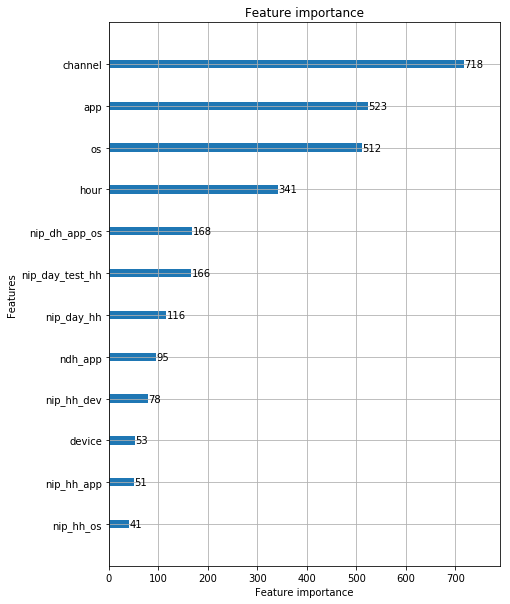

In [53]:
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_model, ax=ax, max_num_features=len(predictors))

In [54]:
pred = lgb_model.predict(valid.loc[:, predictors], num_iteration=lgb_model.best_iteration)

In [55]:
pred.shape

(59633310,)

In [56]:
valid.loc[:, 'pred'] = pred

In [57]:
valid.head()

,app,device,os,channel,is_attributed,hour,nip_day_test_hh,nip_day_hh,nip_hh_os,nip_hh_app,nip_hh_dev,nip_dh_app_os,ndh_app,pred
0,2,1,32,237,0,0,974,90,2,25,88,2,337709,0.009286
1,3,1,25,424,0,0,2594,328,18,88,328,3,718328,0.024804
2,8,2,13,145,0,0,6737,788,147,62,41,2,95558,0.164858
3,2,1,13,122,0,0,302,47,1,4,47,1,337709,0.167543
4,15,1,8,245,0,0,1161,153,3,13,152,1,307250,0.058032


In [58]:
roc_auc_score(valid.loc[:, target], pred)

0.9775600754738255

In [59]:
import pickle

In [60]:
with open('../results/kaggle_popular.pickle', 'wb') as f:
    pickle.dump(lgb_model, f)

In [ ]:
dvalid = lgb.Dataset(
    valid.loc[:, predictors].values,
    label=valid.loc[:, target].values,
    feature_name=predictors,
    categorical_feature=categorical
)

In [ ]:
lgb_model = lgb.train(params, 
                 dtrain, 
                 valid_sets=[dtrain, dvalid], 
                 valid_names=['train','valid'], 
                 evals_result=evals_results, 
                 num_boost_round=1000,
                 early_stopping_rounds=30,
                 verbose_eval=50, 
                 feval=None)